#System Definition and Dataset Generation

In [ ]:
!pip install pypower cvxpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.6/347.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cvxpy as cp

from pypower.api import case14, rundcpf, ppoption
import copy


In [ ]:
# Flexible DC load parameters (MW / MWh)
P_CONST_MW   = 500.0      # constant DC load at bus 14 (MW)
P_FLEX_MAX   = 750.0      # per-hour flex cap (MW)
E_FLEX_MWh   = 6000.0     # total flex energy over 24h (MWh)
T_HOURS      = 24
BUS_DC       = 14         # data center at bus 14 (MATPOWER numbering, 1-based)


In [ ]:
# Load IEEE-14 case
m = case14()
baseMVA = m['baseMVA']
bus = m['bus']
branch = m['branch']

# Column indices in MATPOWER bus/branch matrices
PD_COL = 2      # real power demand
BUS_I_COL = 0   # bus number
RATEA_COL = 5   # branch rateA (MVA limit)

# Find bus index for bus 14 (0-based)
bus_nums = bus[:, BUS_I_COL].astype(int)
bus14_idx = np.where(bus_nums == BUS_DC)[0][0]

# Inject constant DC load (MW) at bus 14 into the case
m_dc = copy.deepcopy(m)
m_dc['bus'][bus14_idx, PD_COL] += P_CONST_MW  # add constant DC load

# DC power flow options
ppopt = ppoption(OUT_ALL=0, VERBOSE=0)

# --- Base DC PF: with constant DC, but no flexible p_t yet ---
res_base, _ = rundcpf(m_dc, ppopt)

branch_base = res_base['branch']
baseMVA = res_base['baseMVA']

# Active power "from" end flows in p.u., convert to MW
PF_COL = 13  # MATPOWER: Pf is column 14 (0-based index 13)
F_base_MW = branch_base[:, PF_COL]   # shape [n_lines]

# Line limits (MVA ~ MW for DC)
F_max_MW = branch[:, RATEA_COL].copy()         # shape [n_lines]
# Some IEEE lines have 0 as rateA -> set a large limit instead of 0
F_max_MW[F_max_MW == 0.0] = 1e4

n_lines = len(F_base_MW)

print("Base flows (MW):", F_base_MW)
print("Line limits (MW):", F_max_MW)
print("Number of lines:", n_lines)


Base flows (MW): [ 469.47166926  249.52833074  135.42065146  192.03263606  160.31838174
   41.22065146 -142.08107745  206.8277881   120.70657687  260.16563503
   24.51584706   51.98024077  172.46954721    0.          206.8277881
  -12.01584706  310.05021202  -21.01584706   45.88024077  204.84978798]
Line limits (MW): [9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900.
 9900. 9900. 9900. 9900. 9900. 9900. 9900. 9900.]
Number of lines: 20


In [ ]:
# --- Sensitivity: +1 MW extra load at bus 14 ---

m_dc_plus = copy.deepcopy(m_dc)
m_dc_plus['bus'][bus14_idx, PD_COL] += 1.0   # +1 MW more load at DC bus

res_plus, _ = rundcpf(m_dc_plus, ppopt)
branch_plus = res_plus['branch']

F_plus_MW = branch_plus[:, PF_COL]

# Sensitivity vector: change in line flow per +1 MW load at bus 14
PTDF_dc = F_plus_MW - F_base_MW   # shape [n_lines]

print("PTDF_dc (MW per MW of DC load):", PTDF_dc)


PTDF_dc (MW per MW of DC load): [ 0.64326615  0.35673385  0.13081203  0.27376157  0.23869255  0.13081203
 -0.16066917  0.35693327  0.2083095   0.43475723  0.035575    0.08874577
  0.31043646  0.          0.35693327 -0.035575    0.60081777 -0.035575
  0.08874577  0.39918223]


In [ ]:
from google.colab import files
import pandas as pd
import io, os

print("Upload a 24-hour price file with columns ['hour','price_usd_per_mwh']...")
up = files.upload()
fname = list(up.keys())[0]
print("Loaded file:", fname)

ext = os.path.splitext(fname)[-1].lower()
if ext == ".csv":
    dfp = pd.read_csv(io.BytesIO(up[fname]))
elif ext in [".xls", ".xlsx"]:
    dfp = pd.read_excel(io.BytesIO(up[fname]))
else:
    raise ValueError("Unsupported file type; please upload CSV or Excel.")

# Basic checks
required_cols = {"hour", "price_usd_per_mwh"}
assert required_cols.issubset(dfp.columns), f"Missing columns. Found: {dfp.columns}"

dfp = dfp.sort_values("hour").reset_index(drop=True)
if len(dfp) != T_HOURS:
    raise ValueError(f"Expected 24 hourly prices, found {len(dfp)}.")

base_prices = dfp["price_usd_per_mwh"].to_numpy().astype(float)
print("Base prices loaded. Min/Max:", base_prices.min(), base_prices.max())


Upload a 24-hour price file with columns ['hour','price_usd_per_mwh']...


Saving price_24h__synthetic_.csv to price_24h__synthetic_.csv
Loaded file: price_24h__synthetic_.csv
Base prices loaded. Min/Max: 16.36 73.95


In [ ]:
def make_price_scenarios(base_prices, n_scenarios=200,
                         noise_scale=5.0,
                         scale_low=0.8, scale_high=1.2,
                         seed=42):
    """
    base_prices: np.array [T]
    returns: np.array [n_scenarios, T]
    """
    rng = np.random.default_rng(seed)
    T = len(base_prices)
    scenarios = []

    for _ in range(n_scenarios):
        noise = rng.normal(loc=0.0, scale=noise_scale, size=T)
        scale = rng.uniform(scale_low, scale_high)
        scen = (base_prices + noise) * scale
        scen = np.clip(scen, 0.0, None)   # no negative prices
        scenarios.append(scen)

    return np.stack(scenarios, axis=0)

N_SCEN = 200
price_scenarios = make_price_scenarios(base_prices, n_scenarios=N_SCEN)
print("Price scenarios shape:", price_scenarios.shape)


Price scenarios shape: (200, 24)


In [ ]:
print("max |F_base| / F_max =", np.max(np.abs(F_base_MW) / F_max_MW))
viol = np.abs(F_base_MW) - F_max_MW
print("Max base flow violation (MW):", np.max(viol))


max |F_base| / F_max = 0.047421380733467876
Max base flow violation (MW): -9430.528330738667


In [ ]:
def solve_dcopf_reference_with_lines(prices,
                                     E_flex,
                                     P_FLEX_MAX,
                                     F_base_MW,
                                     PTDF_dc,
                                     F_max_MW):
    """
    prices: np.array shape (T,), $/MWh
    F_base_MW: np.array shape (n_lines,), base flows (with constant DC)
    PTDF_dc: np.array shape (n_lines,), MW per MW DC load
    F_max_MW: np.array shape (n_lines,), line limits
    """
    T = len(prices)
    nL = len(F_base_MW)

    p = cp.Variable(T)  # flexible DC load, MW

    objective = cp.Minimize(prices @ p)

    constraints = [
        p >= 0,
        p <= P_FLEX_MAX,
        cp.sum(p) == E_FLEX_MWh
    ]

    # Line constraints: for each hour t,
    # F_t = F_base + PTDF_dc * p[t]
    for t in range(T):
        F_t = F_base_MW + PTDF_dc * p[t]
        constraints += [
            F_t <=  F_max_MW,
            F_t >= -F_max_MW,
        ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, eps_abs=1e-5, eps_rel=1e-5, max_iter=10_000)

    return p.value, prob.status, prob.value


In [ ]:
test_p, status, obj = solve_dcopf_reference_with_lines(
    prices=price_scenarios[0],
    E_flex=E_FLEX_MWh,
    P_FLEX_MAX=P_FLEX_MAX,
    F_base_MW=F_base_MW,
    PTDF_dc=PTDF_dc,
    F_max_MW=F_max_MW
)

print("Status:", status)
print("Optimal p (first 5 hours):", np.round(test_p[:5], 2))
print("Sum p:", np.sum(test_p))
print("Objective:", obj)


Status: optimal
Optimal p (first 5 hours): [750.02 749.98 750.   749.98 749.98]
Sum p: 5999.99999999994
Objective: 145112.20338661986


In [ ]:
all_prices = []
all_pstar  = []
all_status = []

for i in range(N_SCEN):
    prices = price_scenarios[i]
    p_star, status, obj = solve_dcopf_reference_with_lines(
        prices=prices,
        E_flex=E_FLEX_MWh,
        P_FLEX_MAX=P_FLEX_MAX,
        F_base_MW=F_base_MW,
        PTDF_dc=PTDF_dc,
        F_max_MW=F_max_MW
    )
    all_prices.append(prices)
    all_pstar.append(p_star)
    all_status.append(status)

    if (i+1) % 20 == 0:
        print(f"Solved {i+1}/{N_SCEN} scenarios, last status = {status}")

all_prices = np.stack(all_prices, axis=0)   # [N, T]
all_pstar  = np.stack(all_pstar,  axis=0)   # [N, T]

print("Dataset shapes:", all_prices.shape, all_pstar.shape)
print("Unique statuses:", set(all_status))


Solved 20/200 scenarios, last status = optimal
Solved 40/200 scenarios, last status = optimal
Solved 60/200 scenarios, last status = optimal
Solved 80/200 scenarios, last status = optimal
Solved 100/200 scenarios, last status = optimal
Solved 120/200 scenarios, last status = optimal
Solved 140/200 scenarios, last status = optimal
Solved 160/200 scenarios, last status = optimal
Solved 180/200 scenarios, last status = optimal
Solved 200/200 scenarios, last status = optimal
Dataset shapes: (200, 24) (200, 24)
Unique statuses: {'optimal'}


In [ ]:
out_name = "dcopf_ieee14_supervised_dataset.npz"
np.savez(
    out_name,
    prices=all_prices,
    p_star=all_pstar,
    P_CONST_MW=P_CONST_MW,
    P_FLEX_MAX=P_FLEX_MAX,
    E_FLEX_MWh=E_FLEX_MWh,
    F_base_MW=F_base_MW,
    PTDF_dc=PTDF_dc,
    F_max_MW=F_max_MW,
)
print("Saved dataset to", out_name)


Saved dataset to dcopf_ieee14_supervised_dataset.npz


# SciML Model

If you have download the generted labels file, then it can be loaded with below cell.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dcopf_ieee14_supervised_dataset.npz to dcopf_ieee14_supervised_dataset.npz


In [ ]:
import numpy as np

data = np.load("dcopf_ieee14_supervised_dataset.npz")

print("Available keys:", data.files)

# Supervised input/output
X = data["prices"]   # shape (N, 24)  – price profiles
Y = data["p_star"]   # shape (N, 24)  – optimal p_t from CVXPY

print("Loaded shapes:", X.shape, Y.shape)

# Optional: meta-parameters (same for all scenarios)
P_CONST_MW = data["P_CONST_MW"].item()
P_FLEX_MAX = data["P_FLEX_MAX"].item()
E_FLEX_MWh = data["E_FLEX_MWh"].item()
F_base_MW  = data["F_base_MW"]
PTDF_dc    = data["PTDF_dc"]
F_max_MW   = data["F_max_MW"]


Available keys: ['prices', 'p_star', 'P_CONST_MW', 'P_FLEX_MAX', 'E_FLEX_MWh', 'F_base_MW', 'PTDF_dc', 'F_max_MW']
Loaded shapes: (200, 24) (200, 24)


In [ ]:
# ---------- 1.2 Loss definition for for NN Cost aware (hybrid: MW MSE + small cost MSE.)
# ---------- Add constants + hybrid loss function ----------
# ---- Problem constants (MUST match Notebook 1) ----
# If you defined p_scale earlier as 750.0, use that:
P_FLEX_MAX = 750.0      # MW, flexible cap (same as in CVXPY dataset)
P_CONST_MW = 500.0      # MW, constant slice of DC load

# Weight for cost term in hybrid loss.
# Start small; we can tune later if needed.
LAMBDA_COST = 0.005

def hybrid_loss(yhat_norm, ytrue_norm, prices_norm):
    """
    yhat_norm  : [batch, 24], NN output in [0,1]
    ytrue_norm : [batch, 24], target p*/P_FLEX_MAX in [0,1]
    prices_norm: [batch, 24], normalized prices (same tensor as xb)
    """

    # ---- 1) MW-space MSE on flexible power ----
    yhat_MW  = yhat_norm  * P_FLEX_MAX   # [B,24]
    ytrue_MW = ytrue_norm * P_FLEX_MAX   # [B,24]

    mse_p = torch.mean((yhat_MW - ytrue_MW)**2)

    # ---- 2) Decision (cost) loss ----
    # We use normalized prices; absolute scale is irrelevant for training
    # as long as relative differences between hours are preserved.
    prices = prices_norm                  # [B,24]

    # Cost per scenario i: sum_t (P_const + p_flex_t) * price_t
    cost_hat  = torch.sum((P_CONST_MW + yhat_MW)  * prices, dim=1)  # [B]
    cost_true = torch.sum((P_CONST_MW + ytrue_MW) * prices, dim=1)  # [B]

    mse_cost = torch.mean((cost_hat - cost_true)**2)

    # ---- 3) Hybrid loss ----
    loss = mse_p + LAMBDA_COST * mse_cost
    return loss, mse_p.detach(), mse_cost.detach()


# Test Prepartion

In [ ]:
# ---------- ----------
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1. Train / val / test split ----------
N = X.shape[0]
perm = np.random.permutation(N)

train_frac, val_frac = 0.8, 0.1
n_train = int(train_frac * N)
n_val   = int(val_frac * N)
n_test  = N - n_train - n_val

idx_train = perm[:n_train]
idx_val   = perm[n_train:n_train+n_val]
idx_test  = perm[n_train+n_val:]

X_train, Y_train = X[idx_train], Y[idx_train]
X_val,   Y_val   = X[idx_val],   Y[idx_val]
X_test,  Y_test  = X[idx_test],  Y[idx_test]

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# ---------- 2. Simple normalization (prices only) ----------
price_mean = X_train.mean(axis=0, keepdims=True)
price_std  = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - price_mean) / price_std
X_val_n   = (X_val   - price_mean) / price_std
X_test_n  = (X_test  - price_mean) / price_std

# (optional) scale outputs by P_FLEX_MAX to keep magnitudes ~1
p_scale = P_FLEX_MAX
Y_train_n = Y_train / p_scale
Y_val_n   = Y_val   / p_scale
Y_test_n  = Y_test  / p_scale

# ---------- 3. Torch tensors & DataLoaders ----------
batch_size = 32

train_ds = TensorDataset(
    torch.from_numpy(X_train_n),
    torch.from_numpy(Y_train_n),
)
val_ds = TensorDataset(
    torch.from_numpy(X_val_n),
    torch.from_numpy(Y_val_n),
)
test_ds = TensorDataset(
    torch.from_numpy(X_test_n),
    torch.from_numpy(Y_test_n),
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print("One batch shapes:",
      next(iter(train_loader))[0].shape,
      next(iter(train_loader))[1].shape)


Train/Val/Test sizes: 160 20 20
One batch shapes: torch.Size([32, 24]) torch.Size([32, 24])


# Main Neural Netwoerk

Using device: cpu
DCOPFNet(
  (net): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=24, bias=True)
  )
  (out_act): Sigmoid()
)
Epoch   1/200: train MSE=2.5007e-01, val MSE=2.4044e-01
Epoch  20/200: train MSE=4.1408e-02, val MSE=4.3171e-02
Epoch  40/200: train MSE=3.0079e-02, val MSE=3.6297e-02
Epoch  60/200: train MSE=2.0629e-02, val MSE=3.2774e-02
Epoch  80/200: train MSE=1.3254e-02, val MSE=2.9412e-02
Epoch 100/200: train MSE=8.3812e-03, val MSE=2.6877e-02
Epoch 120/200: train MSE=5.7515e-03, val MSE=2.5673e-02
Epoch 140/200: train MSE=4.3304e-03, val MSE=2.5159e-02
Epoch 160/200: train MSE=3.4907e-03, val MSE=2.4820e-02
Epoch 180/200: train MSE=2.9328e-03, val MSE=2.4778e-02
Epoch 200/200: train MSE=2.4869e-03, val MSE=2.4886e-02

Total training time: 1.73 s


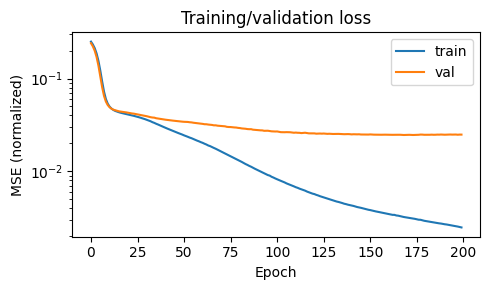

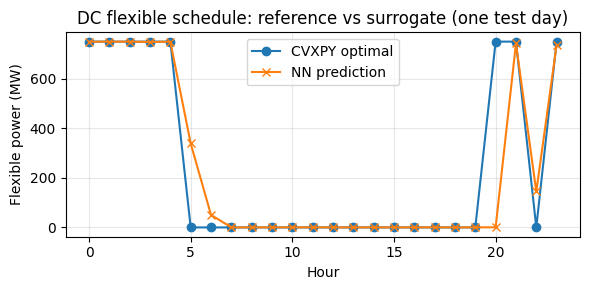

In [ ]:
# ---------- 1.1 Basic NN  ----------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- 1. Model definition ----------
class DCOPFNet(nn.Module):
    """
    Simple feed-forward surrogate:
    input  = 24 normalized prices
    output = 24 normalized flexible powers in [0,1] via sigmoid
    """
    def __init__(self, input_dim=24, hidden_dim=64, num_layers=2):
        super().__init__()
        layers = []
        dim_in = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(dim_in, hidden_dim))
            layers.append(nn.ReLU())
            dim_in = hidden_dim
        layers.append(nn.Linear(dim_in, input_dim))  # back to 24
        self.net = nn.Sequential(*layers)
        self.out_act = nn.Sigmoid()  # enforce 0–1 range

    def forward(self, x):
        z = self.net(x)
        return self.out_act(z)       # normalized p_hat in [0,1]

model = DCOPFNet().to(device)
print(model)

# ---------- 2. Send data to device ----------
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# ---------- 3. Training setup ----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200

train_losses = []
val_losses = []

t0 = time.time()
for epoch in range(num_epochs):
    model.train()
    running_train = 0.0
    n_train_samples = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()

        running_train += loss.item() * xb.size(0)
        n_train_samples += xb.size(0)

    train_loss = running_train / n_train_samples

    # validation
    model.eval()
    running_val = 0.0
    n_val_samples = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yhat = model(xb)
            loss = criterion(yhat, yb)
            running_val += loss.item() * xb.size(0)
            n_val_samples += xb.size(0)
    val_loss = running_val / n_val_samples

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}: "
              f"train MSE={train_loss:.4e}, val MSE={val_loss:.4e}")

t_train = time.time() - t0
print(f"\nTotal training time: {t_train:.2f} s")

# ---------- 4. Plot train/val loss ----------
plt.figure(figsize=(5,3))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized)")
plt.yscale("log")
plt.legend()
plt.title("Training/validation loss")
plt.tight_layout()
plt.show()

# ---------- 5. Test-set evaluation in MW ----------
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        yhat = model(xb)
        all_preds.append(yhat.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

Y_test_pred_n = np.vstack(all_preds)        # normalized
Y_test_true_n = np.vstack(all_targets)

# back to MW
Y_test_pred_MW = Y_test_pred_n * p_scale
Y_test_true_MW = Y_test_true_n * p_scale

err = Y_test_pred_MW - Y_test_true_MW
mse_MW = np.mean(err**2)
mae_MW = np.mean(np.abs(err))
max_abs_err_MW = np.max(np.abs(err))

# ---------- 6. Quick visual check on one random test scenario ----------
k = np.random.randint(Y_test_true_MW.shape[0])
plt.figure(figsize=(6,3))
plt.plot(Y_test_true_MW[k], label="CVXPY optimal", marker="o")
plt.plot(Y_test_pred_MW[k], label="NN prediction", marker="x")
plt.xlabel("Hour")
plt.ylabel("Flexible power (MW)")
plt.title("DC flexible schedule: reference vs surrogate (one test day)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Using device: cpu
DCOPFNet(
  (net): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=24, bias=True)
  )
  (out_act): Sigmoid()
)
Epoch   1/200: hybrid=2.0307e+05, MSE_p=1.3756e+05, MSE_cost=1.3101e+07, val_MSEnorm=1.7512e+05
Epoch  20/200: hybrid=2.8224e+04, MSE_p=2.3534e+04, MSE_cost=9.3801e+05, val_MSEnorm=3.3099e+04
Epoch  40/200: hybrid=2.1153e+04, MSE_p=1.8257e+04, MSE_cost=5.7916e+05, val_MSEnorm=2.7451e+04
Epoch  60/200: hybrid=1.4754e+04, MSE_p=1.2900e+04, MSE_cost=3.7069e+05, val_MSEnorm=2.3439e+04
Epoch  80/200: hybrid=9.8313e+03, MSE_p=8.6863e+03, MSE_cost=2.2900e+05, val_MSEnorm=2.0815e+04
Epoch 100/200: hybrid=6.3654e+03, MSE_p=5.6662e+03, MSE_cost=1.3984e+05, val_MSEnorm=1.8750e+04
Epoch 120/200: hybrid=4.0689e+03, MSE_p=3.6427e+03, MSE_cost=8.5238e+04, val_MSEnorm=1.7500e+04
Epoch 140/200: hybrid=2.9167e+03, MSE_

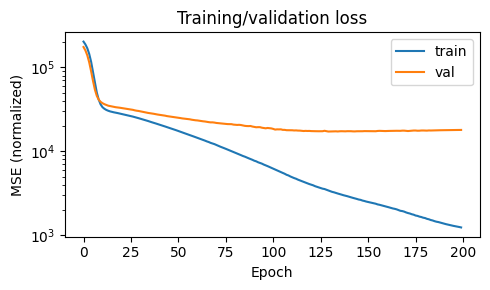

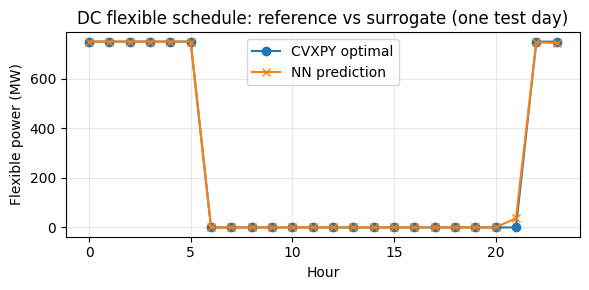

In [ ]:
# ---------- 1.2 NN with Hybrid loss hybrid: MW MSE + small cost MSE ----------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- 1. Model definition ----------
class DCOPFNet(nn.Module):
    """
    Simple feed-forward surrogate:
    input  = 24 normalized prices
    output = 24 normalized flexible powers in [0,1] via sigmoid
    """
    def __init__(self, input_dim=24, hidden_dim=64, num_layers=2):
        super().__init__()
        layers = []
        dim_in = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(dim_in, hidden_dim))
            layers.append(nn.ReLU())
            dim_in = hidden_dim
        layers.append(nn.Linear(dim_in, input_dim))  # back to 24
        self.net = nn.Sequential(*layers)
        self.out_act = nn.Sigmoid()  # enforce 0–1 range

    def forward(self, x):
        z = self.net(x)
        return self.out_act(z)       # normalized p_hat in [0,1]

model = DCOPFNet().to(device)
print(model)

# ---------- 2. Send data to device ----------
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# ---------- 3. Training setup ----------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200

train_losses = []
val_losses = []

t0 = time.time()
for epoch in range(num_epochs):
    model.train()
    running_train = 0.0
    running_train_mse_p = 0.0
    running_train_mse_cost = 0.0
    n_train_samples = 0

    # ---- TRAIN LOOP ----
    for xb, yb in train_loader:
        xb = xb.to(device)   # normalized prices
        yb = yb.to(device)   # normalized p* (p*/P_FLEX_MAX)

        optimizer.zero_grad()
        yhat = model(xb)     # normalized prediction in [0,1]

        loss, mse_p, mse_cost = hybrid_loss(yhat, yb, xb)
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        running_train += loss.item() * batch_size
        running_train_mse_p += mse_p.item() * batch_size
        running_train_mse_cost += mse_cost.item() * batch_size
        n_train_samples += batch_size

    train_loss    = running_train / n_train_samples
    train_mse_p   = running_train_mse_p / n_train_samples
    train_mse_cost= running_train_mse_cost / n_train_samples

    # ---- VALIDATION (still just plain normalized MSE) ----
    model.eval()
    running_val = 0.0
    n_val_samples = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yhat = model(xb)
            val_loss_batch, _, _ = hybrid_loss(yhat, yb, xb)
            running_val += val_loss_batch.item() * xb.size(0)
            n_val_samples += xb.size(0)
    val_loss = running_val / n_val_samples

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}: "
              f"hybrid={train_loss:.4e}, "
              f"MSE_p={train_mse_p:.4e}, "
              f"MSE_cost={train_mse_cost:.4e}, "
              f"val_MSEnorm={val_loss:.4e}")

t_train = time.time() - t0
print(f"\nTotal training time: {t_train:.2f} s")


# ---------- 4. Plot train/val loss ----------
plt.figure(figsize=(5,3))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized)")
plt.yscale("log")
plt.legend()
plt.title("Training/validation loss")
plt.tight_layout()
plt.show()

# ---------- 5. Test-set evaluation in MW ----------
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        yhat = model(xb)
        all_preds.append(yhat.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

Y_test_pred_n = np.vstack(all_preds)        # normalized
Y_test_true_n = np.vstack(all_targets)

# back to MW
Y_test_pred_MW = Y_test_pred_n * p_scale
Y_test_true_MW = Y_test_true_n * p_scale

err = Y_test_pred_MW - Y_test_true_MW
mse_MW = np.mean(err**2)
mae_MW = np.mean(np.abs(err))
max_abs_err_MW = np.max(np.abs(err))

# ---------- 6. Quick visual check on one random test scenario ----------
k = np.random.randint(Y_test_true_MW.shape[0])
plt.figure(figsize=(6,3))
plt.plot(Y_test_true_MW[k], label="CVXPY optimal", marker="o")
plt.plot(Y_test_pred_MW[k], label="NN prediction", marker="x")
plt.xlabel("Hour")
plt.ylabel("Flexible power (MW)")
plt.title("DC flexible schedule: reference vs surrogate (one test day)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Using device: cpu
DCOPFNet(
  (net): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=24, bias=True)
  )
  (out_act): Sigmoid()
)
Epoch   1/200: train MSE=2.1835e-01, val MSE=2.1235e-01
Epoch  20/200: train MSE=4.1166e-02, val MSE=4.3726e-02
Epoch  40/200: train MSE=2.9105e-02, val MSE=3.5911e-02
Epoch  60/200: train MSE=1.9167e-02, val MSE=3.2699e-02
Epoch  80/200: train MSE=1.4144e-02, val MSE=3.1575e-02
Epoch 100/200: train MSE=9.3444e-03, val MSE=3.1536e-02
Epoch 120/200: train MSE=5.2288e-03, val MSE=3.0220e-02
Epoch 140/200: train MSE=3.1621e-03, val MSE=2.9193e-02
Epoch 160/200: train MSE=2.1036e-03, val MSE=2.8634e-02
Epoch 180/200: train MSE=1.5292e-03, val MSE=2.8551e-02
Epoch 200/200: train MSE=1.1910e-03, val MSE=2.8487e-02

Total training time: 6.04 s


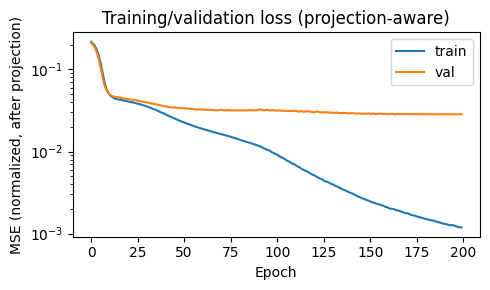

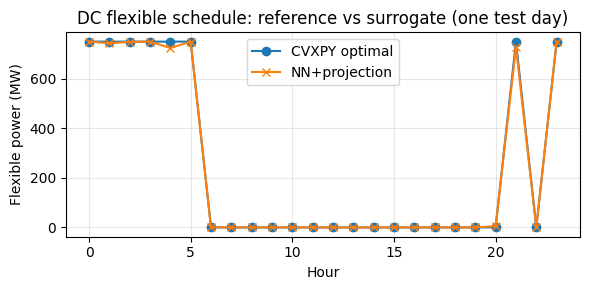

In [ ]:
# ---------- 1.3 NN with Projection layer ----------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

# ---------- 0. Global config ----------
torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

P_FLEX_MAX = 750.0      # MUST match dataset generation
E_flex_MWh = 6000.0     # total flexible energy per day (MWh)

# ---------- 1. Projection layer ----------
def project_to_energy_box(yhat_norm, P_max=P_FLEX_MAX, E_flex=E_flex_MWh):
    """
    yhat_norm: (B, 24) in [0,1] (normalized flexible power)
    Returns: projected normalized schedule in [0,1],
             such that sum_t p_proj ≈ E_flex and 0 <= p <= P_max.

    Steps:
      1) Convert to MW
      2) Scale so total energy = E_flex
      3) Clamp to [0, P_max]
      4) Renormalize once more to hit E_flex after clamping
      5) Back to normalized [0,1]
    """
    # 1) raw MW
    p_raw = yhat_norm * P_max          # (B, 24)

    # 2) scale to match total energy
    #    sum_t p_raw_t * 1h = E_flex MWh
    S = p_raw.sum(dim=1, keepdim=True)  # (B,1)
    eps = 1e-8
    alpha = E_flex / (S + eps)
    p_scaled = p_raw * alpha            # scaled MW

    # 3) clamp to box bounds
    p_clamped = torch.clamp(p_scaled, 0.0, P_max)

    # 4) renormalize after clamping (energy may have changed)
    S2 = p_clamped.sum(dim=1, keepdim=True)
    alpha2 = E_flex / (S2 + eps)
    p_proj = torch.clamp(p_clamped * alpha2, 0.0, P_max)

    # 5) back to normalized
    y_proj = p_proj / P_max
    return y_proj


# ---------- 2. Model definition ----------
class DCOPFNet(nn.Module):
    """
    Surrogate:
      input  = 24 normalized prices
      output = 24 normalized flexible powers in [0,1] via sigmoid
    """
    def __init__(self, input_dim=24, hidden_dim=64, num_layers=2):
        super().__init__()
        layers = []
        dim_in = input_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(dim_in, hidden_dim))
            layers.append(nn.ReLU())
            dim_in = hidden_dim
        layers.append(nn.Linear(dim_in, input_dim))  # back to 24
        self.net = nn.Sequential(*layers)
        self.out_act = nn.Sigmoid()  # enforce [0,1] range

    def forward(self, x):
        z = self.net(x)
        return self.out_act(z)       # normalized p_hat in [0,1]

model = DCOPFNet().to(device)
print(model)

# ---------- 3. DataLoaders ----------
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# ---------- 4. Training setup ----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200

train_losses = []
val_losses = []

t0 = time.time()
for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    running_train = 0.0
    n_train_samples = 0

    for xb, yb in train_loader:
        xb = xb.to(device)   # normalized prices
        yb = yb.to(device)   # normalized CVXPY p* in [0,1]

        optimizer.zero_grad()
        yhat_raw = model(xb)                             # (B,24), in [0,1]
        yhat_proj = project_to_energy_box(yhat_raw)      # (B,24), projected

        loss = criterion(yhat_proj, yb)                  # PROJECTION-AWARE LOSS
        loss.backward()
        optimizer.step()

        running_train += loss.item() * xb.size(0)
        n_train_samples += xb.size(0)

    train_loss = running_train / n_train_samples

    # ---- VALIDATION ----
    model.eval()
    running_val = 0.0
    n_val_samples = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yhat_raw = model(xb)
            yhat_proj = project_to_energy_box(yhat_raw)
            loss = criterion(yhat_proj, yb)
            running_val += loss.item() * xb.size(0)
            n_val_samples += xb.size(0)

    val_loss = running_val / n_val_samples
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}: "
              f"train MSE={train_loss:.4e}, val MSE={val_loss:.4e}")

t_train = time.time() - t0
print(f"\nTotal training time: {t_train:.2f} s")

# ---------- 5. Plot train/val loss ----------
plt.figure(figsize=(5,3))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized, after projection)")
plt.yscale("log")
plt.legend()
plt.title("Training/validation loss (projection-aware)")
plt.tight_layout()
plt.show()

# ---------- 6. Test-set evaluation in MW (AFTER PROJECTION) ----------
model.eval()
all_preds_proj = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        yhat_raw = model(xb)
        yhat_proj = project_to_energy_box(yhat_raw)      # normalized

        all_preds_proj.append(yhat_proj.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

Y_pred_norm = np.vstack(all_preds_proj)   # (N_test, 24)
Y_true_norm = np.vstack(all_targets)      # (N_test, 24)

# back to MW
Y_pred_MW = Y_pred_norm * P_FLEX_MAX
Y_true_MW = Y_true_norm * P_FLEX_MAX

err = Y_pred_MW - Y_true_MW
mse = np.mean(err**2)
mae = np.mean(np.abs(err))
max_err = np.max(np.abs(err))


# ---------- 7. Quick visual check on one random test scenario ----------
k = np.random.randint(Y_true_MW.shape[0])
plt.figure(figsize=(6,3))
plt.plot(Y_true_MW[k], label="CVXPY optimal", marker="o")
plt.plot(Y_pred_MW[k], label="NN+projection", marker="x")
plt.xlabel("Hour")
plt.ylabel("Flexible power (MW)")
plt.title("DC flexible schedule: reference vs surrogate (one test day)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Confirming that network is trained and saved

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Force model to float32 (what we used in training code earlier)
model = model.to(torch.float32).to(device)
model.eval()


DCOPFNet(
  (net): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=24, bias=True)
  )
  (out_act): Sigmoid()
)

# For comparing runtime and sanity checks

In [ ]:
import numpy as np
import torch, time

# -------------------------------------------------
# 1) Make sure we have normalization stats
# -------------------------------------------------
try:
    X_mean
    X_std
    print("Using existing X_mean, X_std.")
except NameError:
    print("X_mean / X_std not found, recomputing from dataset...")
    data = np.load("dcopf_ieee14_supervised_dataset.npz")
    prices_all = data["prices"]          # shape (N, 24)
    X_mean = prices_all.mean(axis=0, keepdims=True)
    X_std  = prices_all.std(axis=0, keepdims=True) + 1e-6

# -------------------------------------------------
# 2) Get one test price vector
# -------------------------------------------------
try:
    prices_all
except NameError:
    data = np.load("dcopf_ieee14_supervised_dataset.npz")
    prices_all = data["prices"]

price_test = prices_all[0]   # (24,)

# -------------------------------------------------
# 3) Helper to run ONE NN inference
# -------------------------------------------------
model.eval()
device = next(model.parameters()).device
model_dtype = next(model.parameters()).dtype  # Float or Double

def run_nn_once(price_vec):
    """Run the trained surrogate once for a single 24-h price vector."""
    price_vec = np.asarray(price_vec, dtype=float).reshape(1, -1)   # (1, 24)
    x_norm = (price_vec - X_mean) / X_std                          # still numpy
    x_t = torch.tensor(x_norm, dtype=model_dtype, device=device)   # match model dtype

    with torch.no_grad():
        _ = model(x_t)   # we only care about timing

# -------------------------------------------------
# 4) Benchmark NN runtime
# -------------------------------------------------
def nn_runtime_benchmark(n_runs=10000):
    t0 = time.time()
    for _ in range(n_runs):
        run_nn_once(price_test)
    t1 = time.time()
    return (t1 - t0) / n_runs

avg_nn_time = nn_runtime_benchmark(n_runs=10000)
print(f"Average NN runtime per 24-h inference: {avg_nn_time*1e3:.4f} ms")


X_mean / X_std not found, recomputing from dataset...
Average NN runtime per 24-h inference: 0.0752 ms


In [ ]:
#Reload dataset
data = np.load("dcopf_ieee14_supervised_dataset.npz")
prices_all = data["prices"]
p_star_all = data["p_star"]
N = prices_all.shape[0]

# Reconstruct X exactly as done before
X = prices_all.astype(float)
Y = p_star_all.astype(float)

# Same normalization you used during training
# (You must define / load X_mean and X_std earlier)
X_norm = (X - X_mean) / X_std

# Recreate train/val/test split EXACTLY like earlier
from sklearn.model_selection import train_test_split

idx_all = np.arange(N)
train_idx, test_idx = train_test_split(idx_all, test_size=0.20, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.111, random_state=42)
# Note: 0.111 * 0.80 = 0.089 -> 8.9% validation = same 20/20/160 split

print("Reconstructed splits:")
print("Train:", len(train_idx), " Val:", len(val_idx), " Test:", len(test_idx))


Reconstructed splits:
Train: 142  Val: 18  Test: 40


In [ ]:
import numpy as np
import torch

# Reload the dataset to have raw prices and CVXPY schedules
data = np.load("dcopf_ieee14_supervised_dataset.npz")
prices_all = data["prices"]          # shape (N, 24)
p_star_all = data["p_star"]          # shape (N, 24)
P_CONST_MW = float(data["P_CONST_MW"])   # scalar base load

# Same normalization stats you used for training
# (should already exist in the notebook)
# X_mean, X_std, device, model, test_idx must already be defined.

def daily_cost(price_vec, p_flex_vec, P_const=P_CONST_MW):
    """Total 24-h cost in $ for one scenario."""
    return float(np.sum((P_const + p_flex_vec) * price_vec))


In [ ]:
# Needed for baseline schedule
E_flex_MWh = 6000.0   # (consistent with dataset generation)

# --- pick the test scenario as before ---
idx = int(test_idx[0])
...


Ellipsis

In [ ]:
# --- pick the test scenario as before ---
idx = int(test_idx[0])
price = prices_all[idx]          # (24,)
p_cvx = p_star_all[idx]          # CVXPY optimal p_flex (24,)

# --- build NN input with matching dtype ---
price_norm = (price - X_mean) / X_std               # still numpy
x_t = torch.tensor(price_norm,
                   dtype=torch.float32,             # match model
                   device=device).unsqueeze(0)      # shape (1, 24)

# --- NN prediction ---
model.eval()
with torch.no_grad():
   p_nn_norm = model(x_t).cpu().numpy().reshape(-1)  # (24,) in [0,1]

# Convert to MW
p_nn = p_nn_norm * P_FLEX_MAX                    # (24,) in MW


# --- cost comparison ---
def daily_cost(price_vec, p_flex_vec):
    # same P_CONST_MW as in dataset
    total_power = P_CONST_MW + p_flex_vec
    return float(np.sum(total_power * price_vec))

C_cvx = daily_cost(price, p_cvx)
C_nn  = daily_cost(price, p_nn)

print(f"CVXPY cost: {C_cvx:,.2f} $")
print(f"NN cost:    {C_nn:,.2f} $")
print(f"Gap:        {C_nn - C_cvx:,.2f} $ ({(C_nn/C_cvx - 1)*100:.3f} %)")


CVXPY cost: 662,295.22 $
NN cost:    635,560.13 $
Gap:        -26,735.09 $ (-4.037 %)


Baseline cost: 798,308.77 $
CVXPY cost:   662,295.22 $  (savings vs baseline: 136,013.54 $, 20.54 %)
NN cost:      635,560.13 $  (savings vs baseline: 162,748.63 $, 25.61 %)


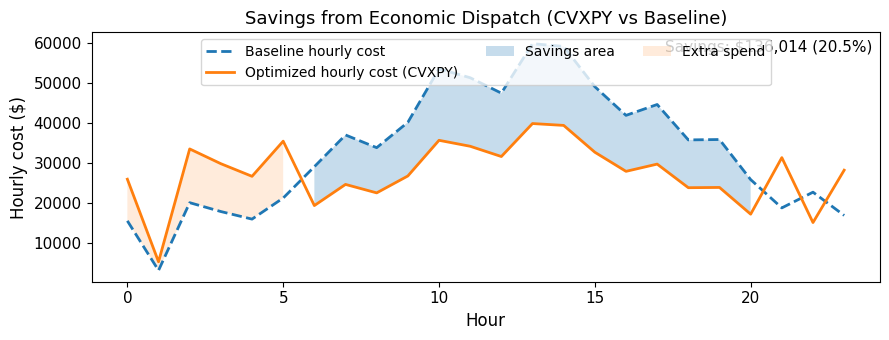

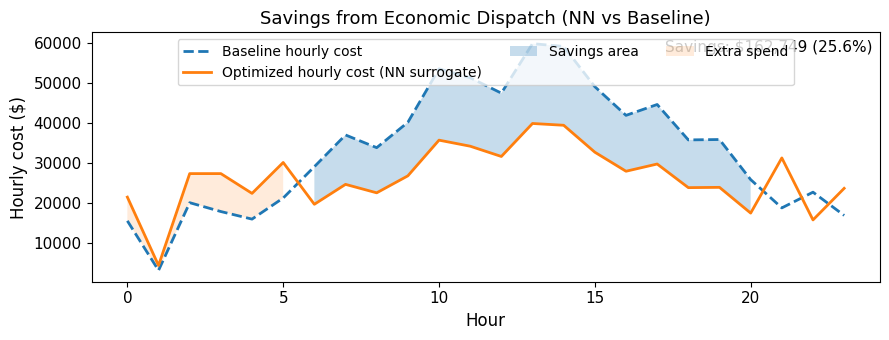

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Build baseline (no optimization) schedule ----------
# Flat flexible load: same total energy E_flex_MWh, spread uniformly
T = price.shape[0]  # should be 24
p_base = np.full_like(p_cvx, E_flex_MWh / T)  # MW

# ---------- 2. Hourly costs for each strategy ----------
def hourly_cost_vec(price_vec, p_flex_vec):
    """
    Returns hourly cost vector (length T) in $ for given price and flexible power.
    Uses same P_CONST_MW as in the CVXPY model.
    """
    total_power = P_CONST_MW + p_flex_vec  # MW
    return total_power * price_vec         # $/h

cost_base = hourly_cost_vec(price, p_base)
cost_cvx  = hourly_cost_vec(price, p_cvx)
cost_nn   = hourly_cost_vec(price, p_nn)

C_base = float(cost_base.sum())
C_cvx  = float(cost_cvx.sum())
C_nn   = float(cost_nn.sum())

print(f"Baseline cost: {C_base:,.2f} $")
print(f"CVXPY cost:   {C_cvx:,.2f} $  (savings vs baseline: {C_base-C_cvx:,.2f} $, {(C_base/C_cvx-1)*100:.2f} %)")
print(f"NN cost:      {C_nn:,.2f} $  (savings vs baseline: {C_base-C_nn:,.2f} $, {(C_base/C_nn-1)*100:.2f} %)")

hours = np.arange(T)

# ---------- 3. Plot: Baseline vs CVXPY (economic dispatch) ----------
plt.figure(figsize=(9, 3.5))
ax = plt.gca()

# Lines
ax.plot(hours, cost_base, linestyle='--', linewidth=2.0, label="Baseline hourly cost")
ax.plot(hours, cost_cvx,  linewidth=2.0, label="Optimized hourly cost (CVXPY)")

# Shaded regions: savings (baseline > cvx) and extra spend (baseline < cvx)
savings_mask = cost_base > cost_cvx
extra_mask   = cost_base < cost_cvx

ax.fill_between(hours, cost_base, cost_cvx,
                where=savings_mask, alpha=0.25, label="Savings area")
ax.fill_between(hours, cost_base, cost_cvx,
                where=extra_mask, alpha=0.15, label="Extra spend")

# Cosmetics
ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Hourly cost ($)", fontsize=12)
ax.set_title("Savings from Economic Dispatch (CVXPY vs Baseline)", fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=10, loc="upper center", ncol=3)

# Annotate total savings
text_str = f"Savings: ${C_base - C_cvx:,.0f} ({(C_base/C_cvx - 1)*100:.1f}%)"
ax.text(0.99, 0.97, text_str,
        transform=ax.transAxes,
        ha="right", va="top", fontsize=11)

plt.tight_layout()
plt.show()

# ---------- 4. Plot: Baseline vs NN surrogate ----------
plt.figure(figsize=(9, 3.5))
ax = plt.gca()

ax.plot(hours, cost_base, linestyle='--', linewidth=2.0, label="Baseline hourly cost")
ax.plot(hours, cost_nn,   linewidth=2.0, label="Optimized hourly cost (NN surrogate)")

savings_mask_nn = cost_base > cost_nn
extra_mask_nn   = cost_base < cost_nn

ax.fill_between(hours, cost_base, cost_nn,
                where=savings_mask_nn, alpha=0.25, label="Savings area")
ax.fill_between(hours, cost_base, cost_nn,
                where=extra_mask_nn, alpha=0.15, label="Extra spend")

ax.set_xlabel("Hour", fontsize=12)
ax.set_ylabel("Hourly cost ($)", fontsize=12)
ax.set_title("Savings from Economic Dispatch (NN vs Baseline)", fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.legend(fontsize=10, loc="upper center", ncol=3)

text_str_nn = f"Savings: ${C_base - C_nn:,.0f} ({(C_base/C_nn - 1)*100:.1f}%)"
ax.text(0.99, 0.97, text_str_nn,
        transform=ax.transAxes,
        ha="right", va="top", fontsize=11)

plt.tight_layout()
plt.show()


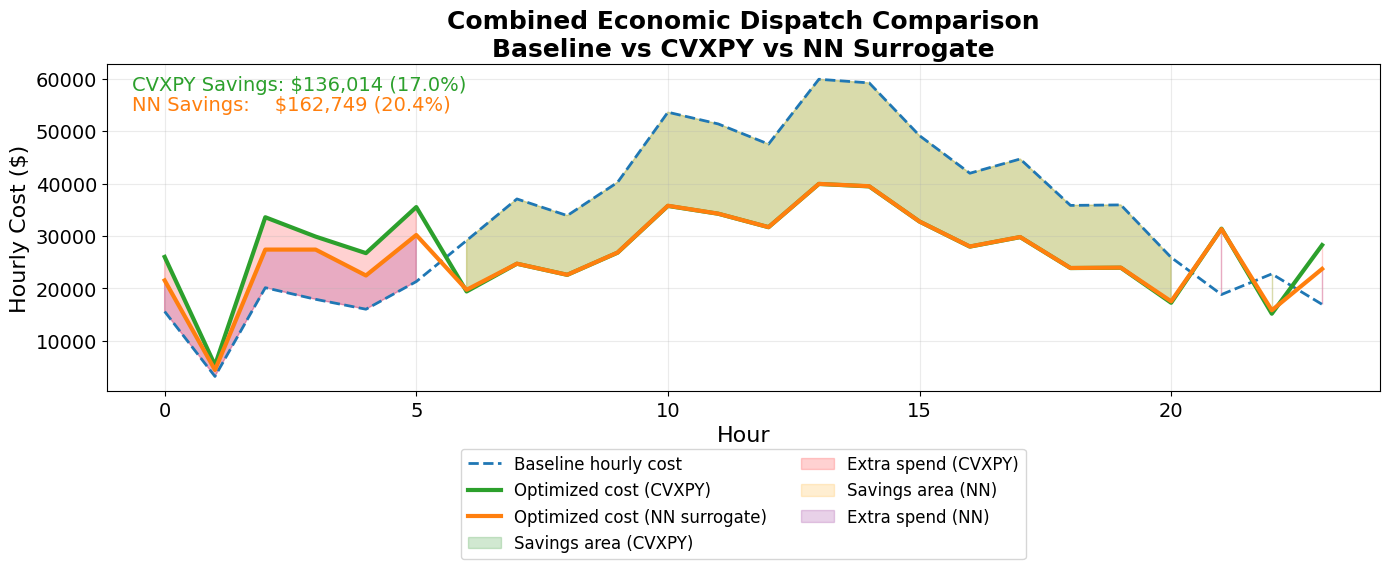

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Compute hourly cost curves for all three strategies
# ------------------------------------------------------------
C_base_hr = (P_CONST_MW + p_base) * price
C_cvx_hr  = (P_CONST_MW + p_cvx) * price
C_nn_hr   = (P_CONST_MW + p_nn)  * price

total_base = C_base_hr.sum()
total_cvx  = C_cvx_hr.sum()
total_nn   = C_nn_hr.sum()

savings_cvx = total_base - total_cvx
savings_nn  = total_base - total_nn

# ------------------------------------------------------------
# 2. Build combined plot
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))

hours = np.arange(len(price))

# --- Baseline curve ---
plt.plot(hours, C_base_hr, "--", color="tab:blue", linewidth=2, label="Baseline hourly cost")

# --- CVXPY curve ---
plt.plot(hours, C_cvx_hr, "-", color="tab:green", linewidth=3, label="Optimized cost (CVXPY)")

# --- NN curve ---
plt.plot(hours, C_nn_hr, "-", color="tab:orange", linewidth=3, label="Optimized cost (NN surrogate)")

# ------------------------------------------------------------
# 3. Fill savings / extra-spend regions
# ------------------------------------------------------------

# CVXPY savings vs baseline
plt.fill_between(
    hours, C_base_hr, C_cvx_hr,
    where=(C_base_hr > C_cvx_hr),
    color="green", alpha=0.18, label="Savings area (CVXPY)"
)

# CVXPY extra spend
plt.fill_between(
    hours, C_base_hr, C_cvx_hr,
    where=(C_base_hr < C_cvx_hr),
    color="red", alpha=0.18, label="Extra spend (CVXPY)"
)

# NN savings vs baseline
plt.fill_between(
    hours, C_base_hr, C_nn_hr,
    where=(C_base_hr > C_nn_hr),
    color="orange", alpha=0.18, label="Savings area (NN)"
)

# NN extra spend
plt.fill_between(
    hours, C_base_hr, C_nn_hr,
    where=(C_base_hr < C_nn_hr),
    color="purple", alpha=0.18, label="Extra spend (NN)"
)

# ------------------------------------------------------------
# 4. Formatting
# ------------------------------------------------------------
plt.title("Combined Economic Dispatch Comparison\nBaseline vs CVXPY vs NN Surrogate",
          fontsize=18, weight="bold")

plt.xlabel("Hour", fontsize=16)
plt.ylabel("Hourly Cost ($)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Place legend at bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
           ncol=2, fontsize=12, frameon=True)

# Annotate savings
plt.text(0.02, 0.92,
         f"CVXPY Savings: ${savings_cvx:,.0f} ({savings_cvx/total_base*100:.1f}%)",
         transform=plt.gca().transAxes, fontsize=14, color="tab:green")

plt.text(0.02, 0.86,
         f"NN Savings:    ${savings_nn:,.0f} ({savings_nn/total_base*100:.1f}%)",
         transform=plt.gca().transAxes, fontsize=14, color="tab:orange")

plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


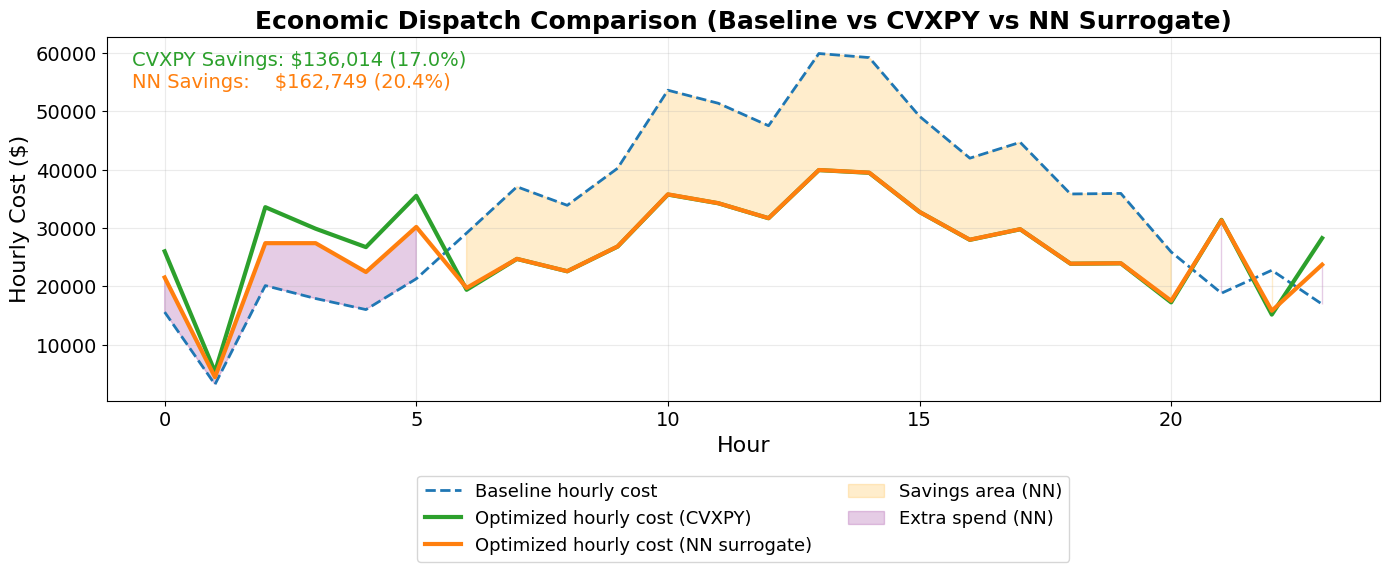

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Compute hourly cost curves
# ------------------------------------------------------------
C_base_hr = (P_CONST_MW + p_base) * price
C_cvx_hr  = (P_CONST_MW + p_cvx) * price
C_nn_hr   = (P_CONST_MW + p_nn)  * price

total_base = C_base_hr.sum()
total_cvx  = C_cvx_hr.sum()
total_nn   = C_nn_hr.sum()

savings_cvx = total_base - total_cvx
savings_nn  = total_base - total_nn

# ------------------------------------------------------------
# 2. Build combined plot
# ------------------------------------------------------------
plt.figure(figsize=(14, 6))

hours = np.arange(len(price))

# --- Baseline ---
plt.plot(hours, C_base_hr, "--", color="tab:blue", linewidth=2,
         label="Baseline hourly cost")

# --- CVXPY (NO SHADING) ---
plt.plot(hours, C_cvx_hr, "-", color="tab:green", linewidth=3,
         label="Optimized hourly cost (CVXPY)")

# --- NN Surrogate ---
plt.plot(hours, C_nn_hr, "-", color="tab:orange", linewidth=3,
         label="Optimized hourly cost (NN surrogate)")

# ------------------------------------------------------------
# 3. NN-only savings shading
# ------------------------------------------------------------

# NN savings
plt.fill_between(
    hours, C_base_hr, C_nn_hr,
    where=(C_base_hr > C_nn_hr),
    color="orange", alpha=0.20,
    label="Savings area (NN)"
)

# NN extra spending
plt.fill_between(
    hours, C_base_hr, C_nn_hr,
    where=(C_base_hr < C_nn_hr),
    color="purple", alpha=0.20,
    label="Extra spend (NN)"
)

# ------------------------------------------------------------
# 4. Formatting
# ------------------------------------------------------------
plt.title("Economic Dispatch Comparison (Baseline vs CVXPY vs NN Surrogate)",
          fontsize=18, weight="bold")

plt.xlabel("Hour", fontsize=16)
plt.ylabel("Hourly Cost ($)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Legend at bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
           ncol=2, fontsize=13, frameon=True)

# Annotate savings
plt.text(0.02, 0.92,
         f"CVXPY Savings: ${savings_cvx:,.0f} ({savings_cvx/total_base*100:.1f}%)",
         transform=plt.gca().transAxes, fontsize=14, color="tab:green")

plt.text(0.02, 0.86,
         f"NN Savings:    ${savings_nn:,.0f} ({savings_nn/total_base*100:.1f}%)",
         transform=plt.gca().transAxes, fontsize=14, color="tab:orange")

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import torch

# NN prediction we already computed:
# price (24,), p_cvx (24,), p_nn (24,)

print("=== Energy constraint check ===")
print("Sum p_cvx:", np.sum(p_cvx))
print("Sum p_nn :", np.sum(p_nn))
print("E_flex   :", E_FLEX_MWh)

print("\n=== Box bounds check ===")
print("p_cvx min/max:", np.min(p_cvx), np.max(p_cvx))
print("p_nn  min/max:", np.min(p_nn), np.max(p_nn))
print("P_FLEX_MAX   :", P_FLEX_MAX)


=== Energy constraint check ===
Sum p_cvx: 6000.000000000013
Sum p_nn : 4689.83
E_flex   : 6000.0

=== Box bounds check ===
p_cvx min/max: -0.0030538526112365064 749.9979816450298
p_nn  min/max: 0.11639528 746.94275
P_FLEX_MAX   : 750.0


In [ ]:
cvx_costs = []
nn_costs  = []

model.eval()
for idx in test_idx:
    price = prices_all[idx]
    p_cvx = p_star_all[idx]

    price_norm = (price - X_mean) / X_std
    x_t = torch.tensor(price_norm, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        p_nn_norm = model(x_t).cpu().numpy().reshape(-1)
    p_nn = p_nn_norm * P_FLEX_MAX

    cvx_costs.append(daily_cost(price, p_cvx))
    nn_costs.append(daily_cost(price, p_nn))

cvx_costs = np.array(cvx_costs)
nn_costs  = np.array(nn_costs)
diff      = nn_costs - cvx_costs
reldiff   = diff / cvx_costs

print("\n=== Test set cost stats ===")
print(f"Mean abs cost diff : ${np.mean(np.abs(diff)):.2f}")
print(f"Max  abs cost diff : ${np.max(np.abs(diff)):.2f}")
print(f"Mean rel diff      : {np.mean(reldiff)*100:.4f} %")
print(f"Max  rel diff      : {np.max(np.abs(reldiff))*100:.4f} %")



=== Test set cost stats ===
Mean abs cost diff : $20639.97
Max  abs cost diff : $59606.52
Mean rel diff      : -3.2179 %
Max  rel diff      : 8.1684 %


In [ ]:
import numpy as np
import torch

eps = 1e-6  # for MAPE to avoid divide-by-zero

cvx_costs = []
nn_costs  = []

mse_list   = []   # MSE of p schedule (MW^2) per scenario
mape_list  = []   # MAPE (%) of p schedule per scenario

max_viol_cvx_list = []  # max line violation (MW) per scenario, CVXPY
max_viol_nn_list  = []  # same for NN

model.eval()
for idx in test_idx:
    # ----- prices and CVXPY optimal p* -----
    price = prices_all[idx]          # shape (24,)
    p_cvx = p_star_all[idx]          # shape (24,)

    # ----- NN prediction for this scenario -----
    price_norm = (price - X_mean) / X_std
    x_t = torch.tensor(price_norm, dtype=torch.float32, device=device).unsqueeze(0)

    with torch.no_grad():
        p_nn_norm = model(x_t).cpu().numpy().reshape(-1)   # in [0,1]
    p_nn = p_nn_norm * P_FLEX_MAX                          # back to MW

    # ----- cost metrics -----
    C_cvx = daily_cost(price, p_cvx)
    C_nn  = daily_cost(price, p_nn)

    cvx_costs.append(C_cvx)
    nn_costs.append(C_nn)

    # ----- power-profile error metrics (per scenario) -----
    diff = p_nn - p_cvx

    # MSE in MW^2
    mse = np.mean(diff**2)
    mse_list.append(mse)



    # ----- flow-violation metrics (per scenario), if data available -----
    if ('PTDF_dc' in globals()) and (PTDF_dc is not None) and \
       ('F_max_MW' in globals()) and (F_max_MW is not None):

        PTDF = np.asarray(PTDF_dc)      # shape (L,)  – one PTDF per line
        Fmax = np.asarray(F_max_MW)     # shape (L,)

        if ('F_base_MW' in globals()) and (F_base_MW is not None):
            Fbase = np.asarray(F_base_MW)   # shape (L,)
        else:
            Fbase = np.zeros_like(Fmax)

        # flows under CVXPY and NN, shape (L, 24)
        F_cvx = Fbase[:, None] + PTDF[:, None] * p_cvx[None, :]
        F_nn  = Fbase[:, None] + PTDF[:, None] * p_nn[None, :]

        # violations per line per hour
        viol_cvx = np.maximum(np.abs(F_cvx) - Fmax[:, None], 0.0)
        viol_nn  = np.maximum(np.abs(F_nn)  - Fmax[:, None], 0.0)

        # store worst violation over all lines & hours for this scenario
        max_viol_cvx_list.append(np.max(viol_cvx))
        max_viol_nn_list.append(np.max(viol_nn))


# ----- convert to arrays -----
cvx_costs = np.array(cvx_costs)
nn_costs  = np.array(nn_costs)
diff      = nn_costs - cvx_costs
reldiff   = diff / cvx_costs

mse_arr   = np.array(mse_list)
mape_arr  = np.array(mape_list)

print("\n=== Test set cost stats ===")
print(f"Mean abs cost diff : ${np.mean(np.abs(diff)):.2f}")
print(f"Max  abs cost diff : ${np.max(np.abs(diff)):.2f}")
print(f"Mean rel diff      : {np.mean(reldiff)*100:.4f} %")
print(f"Max  rel diff      : {np.max(np.abs(reldiff))*100:.4f} %")

# ----- power-profile stats -----
print("\n=== Test set power-profile error stats ===")
print(f"Mean MSE (MW^2)    : {np.nanmean(mse_arr):.3f}")
print(f"Mean MSE% (vs P_max^2): {np.nanmean(mse_arr) / (P_FLEX_MAX**2) * 100:.5f} %")


# ----- flow-violation stats -----
if len(max_viol_cvx_list) > 0:
    max_viol_cvx_arr = np.array(max_viol_cvx_list)
    max_viol_nn_arr  = np.array(max_viol_nn_list)

    print("\n=== Test set line-flow violation stats ===")
    print(f"Mean max viol (CVXPY): {np.mean(max_viol_cvx_arr):.3f} MW")
    print(f"Mean max viol (NN)   : {np.mean(max_viol_nn_arr):.3f} MW")
    print(f"Max  viol (CVXPY)    : {np.max(max_viol_cvx_arr):.3f} MW")
    print(f"Max  viol (NN)       : {np.max(max_viol_nn_arr):.3f} MW")
    print(f"Mean Δmax viol (NN-CVXPY): {np.mean(max_viol_nn_arr - max_viol_cvx_arr):.3f} MW")
else:
    print("\n(No PTDF / line-limit data available, skipping flow-violation stats.)")



=== Test set cost stats ===
Mean abs cost diff : $20639.97
Max  abs cost diff : $59606.52
Mean rel diff      : -3.2179 %
Max  rel diff      : 8.1684 %

=== Test set power-profile error stats ===
Mean MSE (MW^2)    : 10723.020
Mean MSE% (vs P_max^2): 1.90631 %

=== Test set line-flow violation stats ===
Mean max viol (CVXPY): 0.000 MW
Mean max viol (NN)   : 0.000 MW
Max  viol (CVXPY)    : 0.000 MW
Max  viol (NN)       : 0.000 MW
Mean Δmax viol (NN-CVXPY): 0.000 MW
